# Shallow Water Equation - Gammelt, bruges ikke

## Load packages

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

from scipy.io import loadmat


## Solve the 1D SWE using the Finite Volume Method with a Riemann solver



In [4]:
def riemann_solver(hL, huL, hR, huR, g=9.81, solver='roe'):
    # Compute fluxes
    F_L = np.array([huL, huL**2 / hL + 0.5 * g * hL**2])
    F_R = np.array([huR, huR**2 / hR + 0.5 * g * hR**2])

    # Calculate Roe averages
    h_tilde = (hL + hR) / 2
    u_tilde = (np.sqrt(hL) * huL / hL + np.sqrt(hR) * huR / hR) / (np.sqrt(hL) + np.sqrt(hR))

    c = np.sqrt(g * h_tilde)

    # Calculate eigenvalues and eigenvectors
    lambda1 = u_tilde - c
    lambda2 = u_tilde + c
    R1 = np.array([1, lambda1])
    R2 = np.array([1, lambda2])

    # Compute wave strengths
    dh = hR - hL
    du = huR/hR - huL/hL
    alpha1 = 0.5*(dh - h_tilde/c * du)
    alpha2 = 0.5*(dh + h_tilde/c * du)

    # Compute values for HLL
    uL = huL / hL
    uR = huR / hR
    cL = np.sqrt(g * hL)
    cR = np.sqrt(g * hR)
    sL = np.min([uL - cL, uR - cR])
    sR = np.max([uL + cL, uR + cR])

    # Compute the HLL or Roe flux
    if solver == 'hll':
        if sL >= 0:
            F = F_L
        elif sR <= 0:
            F = F_R
        else:
            F = (sR * F_L - sL * F_R + sL * sR * (np.array([hR, huR]) - np.array([hL, huL]))) / (sR - sL)
    else:
        F = 0.5 * (F_L + F_R) - 0.5 * (alpha1 * np.abs(lambda1) * R1 + alpha2 * np.abs(lambda2) * R2)
    
    return F

    
def compute_interface_fluxes(h, hu, N, g, solver):
    fluxes = np.zeros((2, N+1))
    
    hL, huL = h[0], -hu[0]  
    hR, huR = h[1], hu[1]
    fluxes[:, 0] = riemann_solver(hL, huL, hR, huR, g, solver=solver)
    
    for i in range(1, N):
        fluxes[:, i] = riemann_solver(h[i-1], hu[i-1], h[i], hu[i], g, solver=solver)
    
    hL, huL = h[N-2], hu[N-2]
    hR, huR = h[N-1], -hu[N-1]

    fluxes[:, N] = riemann_solver(hL, huL, hR, huR, g, solver=solver)
    
    return fluxes

def update_variables(h, hu, dt, fluxes, N, dx):
    h_new = h.copy()
    hu_new = hu.copy()
    
    for i in range(1, N-1):
        h_new[i] = h[i] - dt/dx * (fluxes[0, i+1] - fluxes[0, i])
        hu_new[i] = hu[i] - dt/dx * (fluxes[1, i+1] - fluxes[1, i])
        
    # Apply reflective boundary conditions
    h_new[0] = h_new[1]
    hu_new[0] = -hu_new[1]
    h_new[N-1] = h_new[N-2]
    hu_new[N-1] = -hu_new[N-2]
 
   
    return h_new, hu_new

# putting it all together
def solve_SWE_1D(t, t_end, h, hu, N, dx, CFL=0.9,g=9.81, solver='roe'):
    # Store the intermediate states
    h_hist = []
    hu_hist = []
    dt_hist = []

    h_hist.append(h.copy())
    hu_hist.append(hu.copy())

    # Main loop
    while t < t_end:
        # Compute the time step
        u = hu/h
        c = np.sqrt(g*h)
        dt = CFL * dx/np.max(np.abs(u) + c)

        if t + dt > t_end:
            dt = t_end - t
        
        # Compute the fluxes at the interfaces
        fluxes = compute_interface_fluxes(h, hu, N, g, solver)

        # Update the variables
        h, hu = update_variables(h, hu, dt, fluxes, N, dx)

        # Store the results
        h_hist.append(h.copy())
        hu_hist.append(hu.copy())
        dt_hist.append(dt)

        # Update the time
        t += dt

    n = len(dt_hist)

    print(f"Number of time steps: {n}")

    return h, hu, h_hist

## Dam break problem 1

In [5]:
# Initialization
N = 50 # Number of grid points
L = 1 # Length of the domain

dx = L / N
x = np.linspace(0, L, N)

CFL = 0.9 # CFL number
g = 9.81 # Gravity

# Initial conditions
h = np.ones(N)
hu = np.zeros(N)
u = np.zeros(N)

h[int(N/4):int(3*N/4)] = 2.0  # higher water level in the middle

t = 0
t_end = 0.5

h, hu, h_hist = solve_SWE_1D(t, t_end, h, hu, N, dx, CFL=0.9,g=9.81, solver='roe')

#subplot_solution(x, h, hu, h_hist, save=False, filename='VSC/tex/plots/solution.png')
n = len(h_hist)
idx = [0, 10, 20]
subplot(h_hist, idx, L, N, save=False, filename='VSC/tex/plots/solution_1D_no_limiter.png')
idx = [60, 100, 130]
subplot(h_hist, idx, L, N, save=False, filename='VSC/tex/plots/solution_1D_no_limiter_2.png')


Number of time steps: 135


NameError: name 'subplot' is not defined

In [15]:
if 0:    
    fig, ax = plt.subplots(figsize=(10, 6))

    def update_plot(index):
        ax.clear()
        ax.plot(np.linspace(0, L, N), h_hist[index])
        ax.set_xlabel('Distance (x)')
        ax.set_ylabel('Water Height (h)')
        ax.set_title(f'Time step {index}/{len(h_hist) - 1}')
        ax.set_ylim(0, 2.1)  # Adjust this based on the expected range of water height
        ax.set_xlim(0, L)     # Ensure x-axis limits are consistent

    # Create animation
    ani = animation.FuncAnimation(fig, update_plot, frames=len(h_hist), interval=100)

    # Display the animation
    HTML(ani.to_jshtml())


In [16]:
#ani.save('animation_26062024_prob1.html', writer='html')
#dpi = 200
#ani.save('animation_26062024_prob1.gif', writer='pillow', dpi = dpi)

## Comparason HLL and ROE solver

Number of time steps: 135
Number of time steps: 134


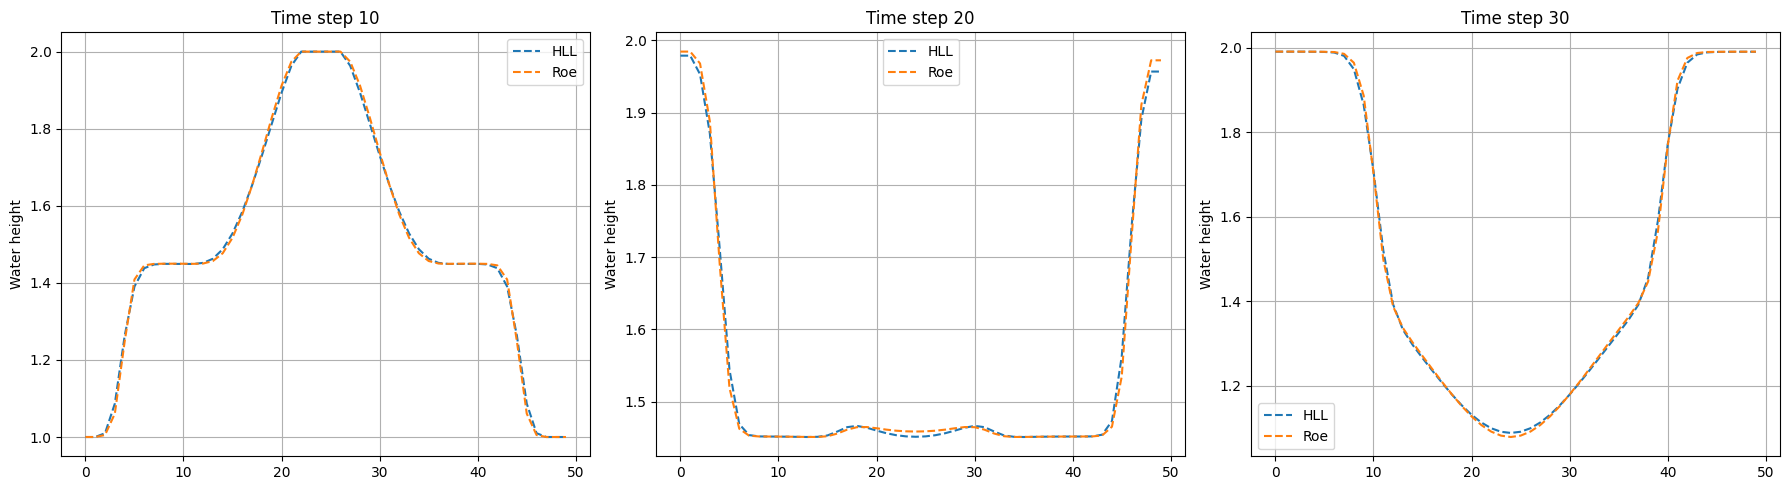

In [17]:
# Initialization
N = 50 # Number of grid points
L = 1 # Length of the domain

dx = L / N
x = np.linspace(0, L, N)

CFL = 0.9 # CFL number
g = 9.81 # Gravity

# Initial conditions
h = np.ones(N)
hu = np.zeros(N)
u = np.zeros(N)

h[int(N/4):int(3*N/4)] = 2.0  # higher water level in the middle

t = 0
t_end = 0.5

h_roe, hu_roe, h_hist_roe = solve_SWE_1D(t, t_end, h, hu, N, dx, CFL=0.9,g=9.81, solver='roe')

# Initial conditions
h = np.ones(N)
hu = np.zeros(N)
u = np.zeros(N)

h[int(N/4):int(3*N/4)] = 2.0  # higher water level in the middle

h_hll, hu_hll, h_hist_hll = solve_SWE_1D(t, t_end, h, hu, N, dx, CFL=0.9,g=9.81, solver='hll')

# Indexes to plot
indices = [10, 20, 30]

# Create a figure with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot for each idx in the subplot
for i, idx in enumerate(indices):
    axes[i].plot(h_hist_hll[idx], label='HLL', linestyle='--')
    axes[i].plot(h_hist_roe[idx], label='Roe', linestyle='--')
    axes[i].set_title(f'Time step {idx}')
    axes[i].set_ylabel('Water height')
    axes[i].legend()
    axes[i].grid()

# Show the plot
plt.tight_layout()
plt.show()


## Dam break problem 2 - verify with exact solution

In [100]:
# Load the .mat file
mat_data = loadmat('data/dambreakdata.mat')

h_sol = mat_data['h']
u_sol = mat_data['u']

h_sol = np.array(h_sol[0, :])
u_sol = np.array(u_sol[0, :])


Number of time steps: 79


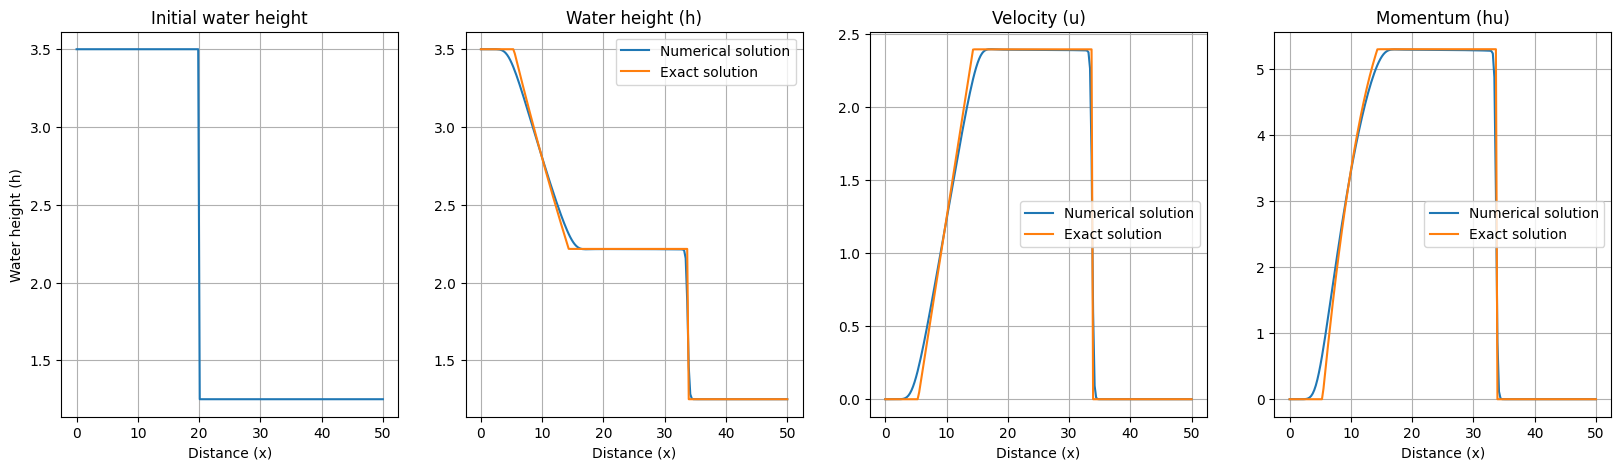

In [101]:
# Initialization
N = 200 # Number of grid points
L = 50 # Length of the domain
dx = L / N
x = np.linspace(0, L, N)

# Initial conditions
g = 9.81

hl = 3.5
hr = 1.25
h = np.where(x < 20, hl, hr)
hu = np.zeros(N)
u = np.zeros(N)

t = 0
t_end = 2.5

h, hu, h_hist = solve_SWE_1D(t, t_end, h, hu, N, dx, CFL=0.9,g=9.81,solver='roe')

# Make 4 subplots
subplot_solution(x, h, hu, h_hist, h_sol, u_sol, save=False, filename='../tex/plots/sol_1D_val.png', sol=True)



Number of time steps: 126


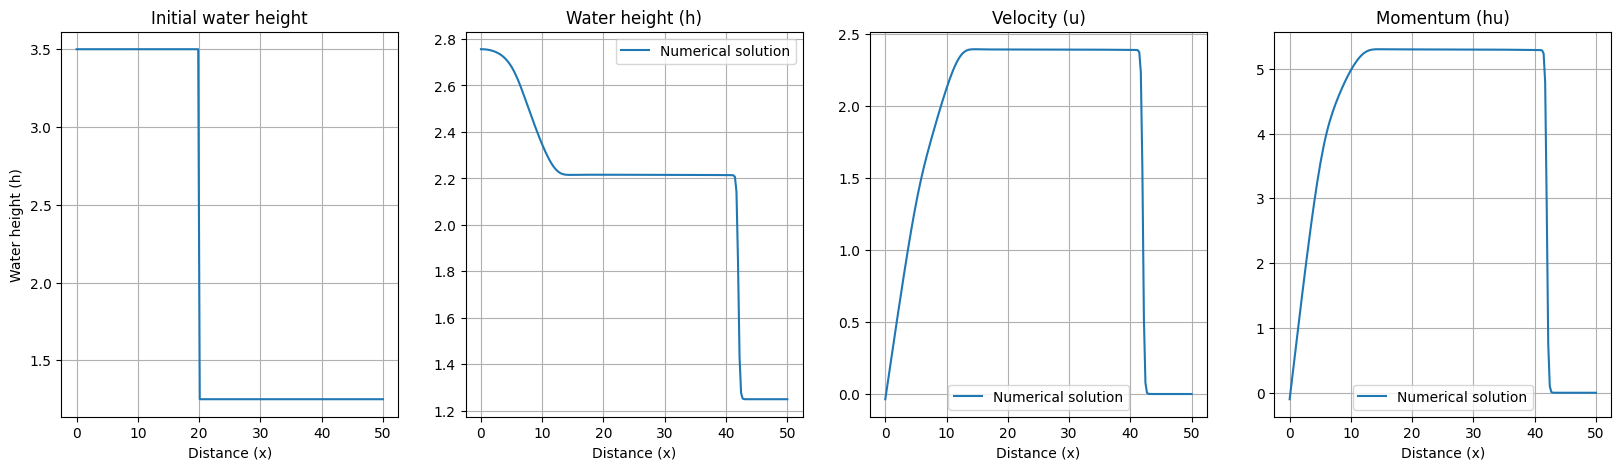

In [112]:
# Simulate up to t = 4
h = np.where(x < 20, hl, hr)
hu = np.zeros(N)
u = np.zeros(N)

t = 0
t_end = 4

h, hu, h_hist = solve_SWE_1D(t, t_end, h, hu, N, dx, CFL=0.9,g=9.81)

# Make 4 subplots
subplot_solution(x, h, hu, h_hist, t, t, save=False, filename='VSC/tex/plots/sol_1D_val_no_limiter.png', sol=False)

In [110]:
if 0:    
    fig, ax = plt.subplots(figsize=(10, 6))

    def update_plot(index):
        ax.clear()
        ax.plot(np.linspace(0, L, N), h_hist[index])
        ax.set_xlabel('Distance (x)')
        ax.set_ylabel('Water Height (h)')
        ax.set_title(f'Time step {index}/{len(h_hist) - 1}')
        ax.set_ylim(0, 3.6)  # Adjust this based on the expected range of water height
        ax.set_xlim(0, L)     # Ensure x-axis limits are consistent
        ax.grid(True)
        
    # Create animation
    ani = animation.FuncAnimation(fig, update_plot, frames=len(h_hist), interval=100)

    # Display the animation
    HTML(ani.to_jshtml())


In [111]:
# Save animation as a gif
#ani.save('animation_26092024_val.html', writer='html')
#dpi = 200
#ani.save('animation_26092024_val.gif', writer='pillow', dpi = dpi)

## Methods of manufactored solutions


In [23]:
# Parameters
H0 = 10 # Initial water height
A = 1 # Amplitude of the wave
k = 2*np.pi/10 # Wave number
omega = np.pi # Angular frequency
omega = 10
g = 9.81 # Gravity

# Manufactured solution
def height(x, t):
    return H0 + A*np.sin(k*x - omega*t)

def u_velocity(x, t):
    return -A * (omega/k) * np.cos(k*x - omega*t)

# Compute source terms
def source_terms_h(x, t):
    return -A * omega * np.sin(k*x) * np.sin(omega * t)

def source_terms_u(x, t):
    return -A * omega**2 * np.sin(k*x) * np.cos(omega * t)/k



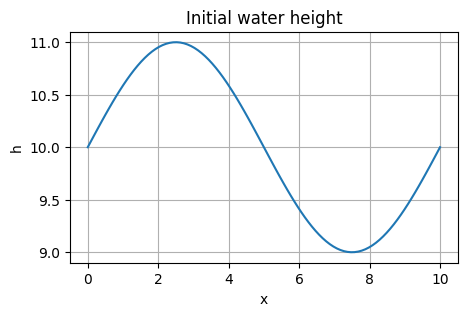

In [24]:
L = 10
N = 100

x = np.linspace(0, L, N)
h = height(x, 0)

plt.figure(figsize=(5, 3))
plt.plot(x, h)
plt.xlabel('x')
plt.ylabel('h')
plt.title('Initial water height')
plt.grid(True)
plt.show()


Number of time steps: 120


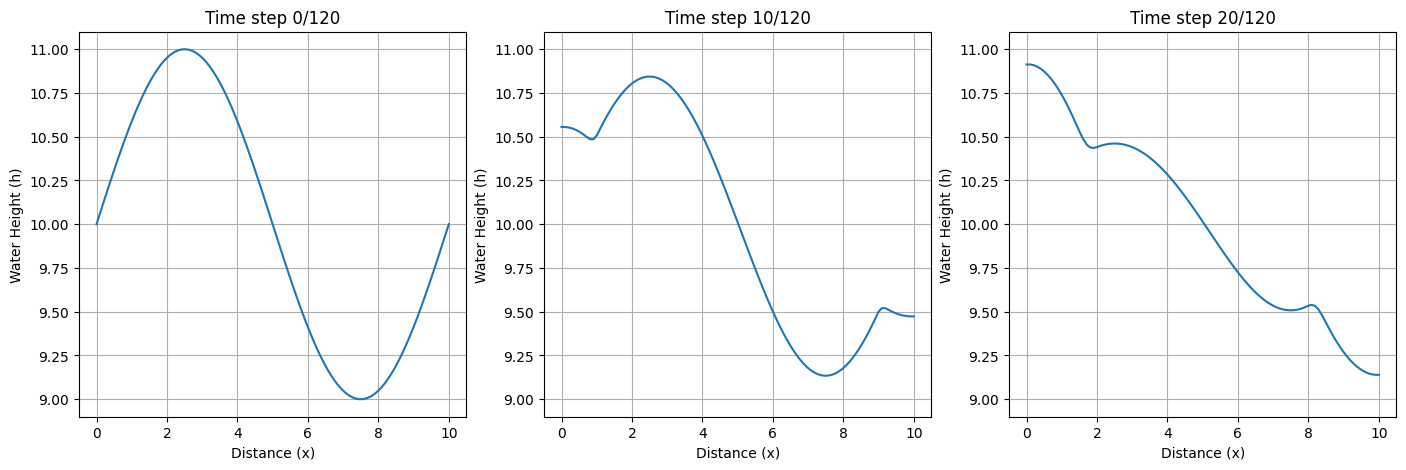

In [25]:
# Initialization
N = 100 # Number of grid points
L = 10 # Length of the domain
dx = L / N
x = np.linspace(0, L, N)

# Initial conditions
g = 9.81

hl = 3.5
hr = 1.25
h = np.where(x < 20, hl, hr)
h = height(x, 0)

hu = np.zeros(N)
u = np.zeros(N)

t = 0
t_end = 1

h, hu, h_hist = solve_SWE_1D(t, t_end, h, hu, N, dx, CFL=0.9,g=9.81,solver='roe')

n = len(h_hist)
idx = [0, 10, 20]
subplot(h_hist, idx, L, N, save=False, filename='VSC/tex/plots/solution_1D_no_limiter.png')
#idx = [60, 100, 130]
#subplot(h_hist, idx, L, N, save=False, filename='VSC/tex/plots/solution_1D_no_limiter_2.png')



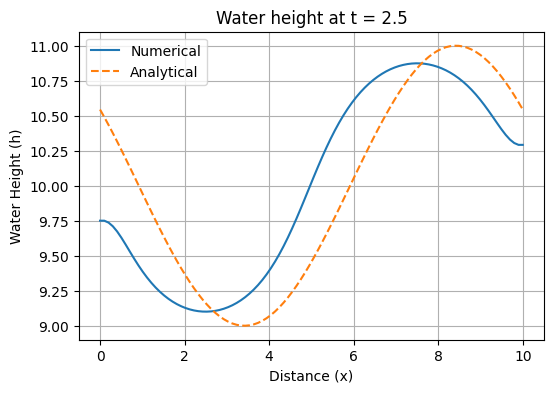

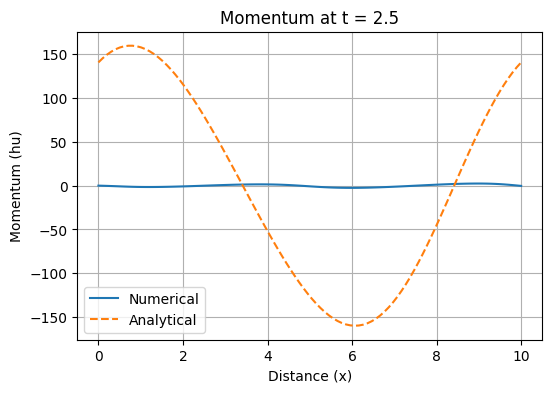

In [26]:
# Make 4 subplots
plt.figure(figsize=(6, 4))
plt.plot(x, h, label='Numerical')
plt.plot(x, height(x, t_end), label='Analytical', linestyle='--')
plt.xlabel('Distance (x)')
plt.ylabel('Water Height (h)')
plt.title('Water height at t = 2.5')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(x, hu, label='Numerical')
plt.plot(x, height(x, t_end)*u_velocity(x, t_end), label='Analytical', linestyle='--')
plt.xlabel('Distance (x)')
plt.ylabel('Momentum (hu)')
plt.title('Momentum at t = 2.5')
plt.legend()
plt.grid(True)
plt.show()

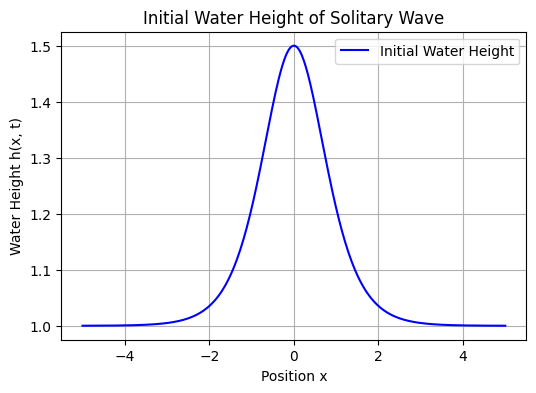

In [128]:
# Parameters for the solitary wave
h0 = 1.0         # Base water depth
A = 0.5          # Amplitude of the wave
c = 1.0          # Wave speed
lambda_ = 1.0    # Width of the wave

# Function to calculate the water height at position x and time t
def water_height(x, t):
    argument = (x - c * t) / lambda_
    return h0 + A * (1 / np.cosh(argument))**2

def velocity(x, t):
    h = water_height(x, t)  # Calculate the water height
    return c * (1 - A / (h0 + A * (1 / np.cosh((x - c * t) / lambda_)**2)))

# Define the spatial domain and time
x = np.linspace(-5, 5, 400)  # Spatial domain from -5 to 5
t = 0                        # Initial time

# Compute the water height at initial time
h_initial = water_height(x, t)

# Plot the initial water height
plt.figure(figsize=(6, 4))
plt.plot(x, h_initial, label='Initial Water Height', color='b')
plt.xlabel('Position x')
plt.ylabel('Water Height h(x, t)')
plt.title('Initial Water Height of Solitary Wave')
plt.legend()
plt.grid(True)
plt.show()


In [133]:
# Compute the water height at initial time
h = water_height(x, t)
u = velocity(x, t)
hu = h * u

array([0.50004539, 0.50005555, 0.50006798, 0.5000832 , 0.50010182,
       0.5001246 , 0.50015248, 0.50018659, 0.50022832, 0.50027938,
       0.50034184, 0.50041824, 0.50051168, 0.50062595, 0.50076565,
       0.50093642, 0.50114509, 0.50140001, 0.50171129, 0.50209119,
       0.50255456, 0.50311932, 0.50380699, 0.50464341, 0.50565935,
       0.50689129, 0.50838213, 0.51018186, 0.51234805, 0.51494599,
       0.51804829, 0.52173375, 0.52608494, 0.53118442, 0.53710892,
       0.54392162, 0.55166217, 0.56033514, 0.56989793, 0.58024956,
       0.59122278, 0.60258168, 0.61402658, 0.62520701, 0.63574185,
       0.64524422, 0.6533477 , 0.65973052, 0.66413537, 0.66638349,
       0.66638349, 0.66413537, 0.65973052, 0.6533477 , 0.64524422,
       0.63574185, 0.62520701, 0.61402658, 0.60258168, 0.59122278,
       0.58024956, 0.56989793, 0.56033514, 0.55166217, 0.54392162,
       0.53710892, 0.53118442, 0.52608494, 0.52173375, 0.51804829,
       0.51494599, 0.51234805, 0.51018186, 0.50838213, 0.50689

Number of time steps: 27


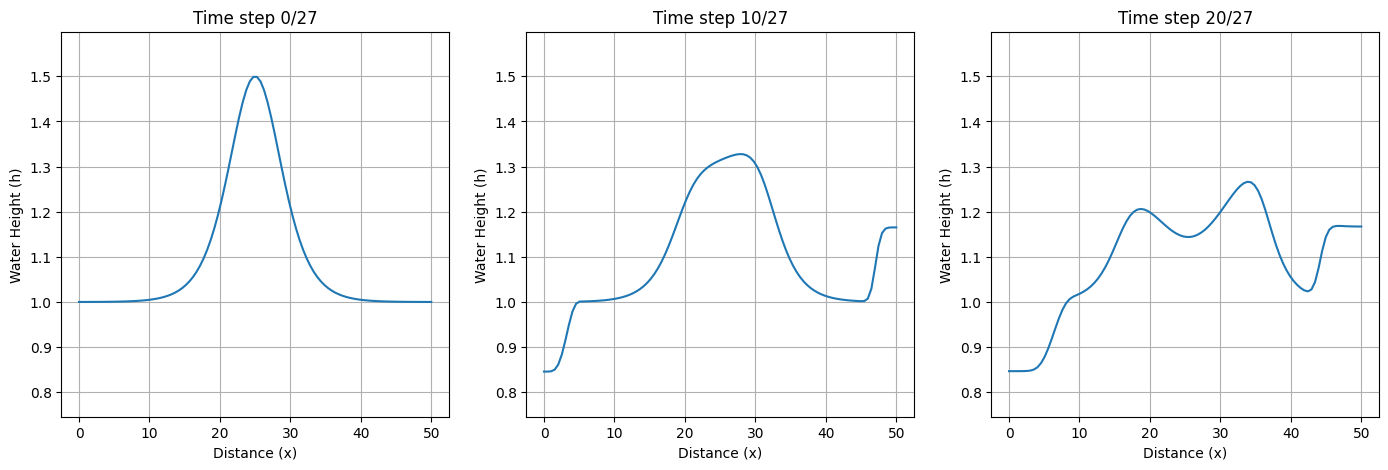

In [129]:
# Initialization
N = 100
# Define the spatial domain and time
x = np.linspace(-5, 5, N)  # Spatial domain from -5 to 5
t = 0                        # Initial time

# Compute the water height at initial time
h = water_height(x, t)
u = velocity(x, t)
hu = h * u

#u = np.zeros(N)
#hu = np.zeros(N)

t = 0
t_end = 1

h, hu, h_hist = solve_SWE_1D(t, t_end, h, hu, N, dx, CFL=0.9,g=9.81,solver='roe')

n = len(h_hist)
idx = [0, 10, 20]
subplot(h_hist, idx, L, N, save=False, filename='VSC/tex/plots/solution_1D_no_limiter.png')
#idx = [60, 100, 130]
#subplot(h_hist, idx, L, N, save=False, filename='VSC/tex/plots/solution_1D_no_limiter_2.png')
# Compute the water height at initial time

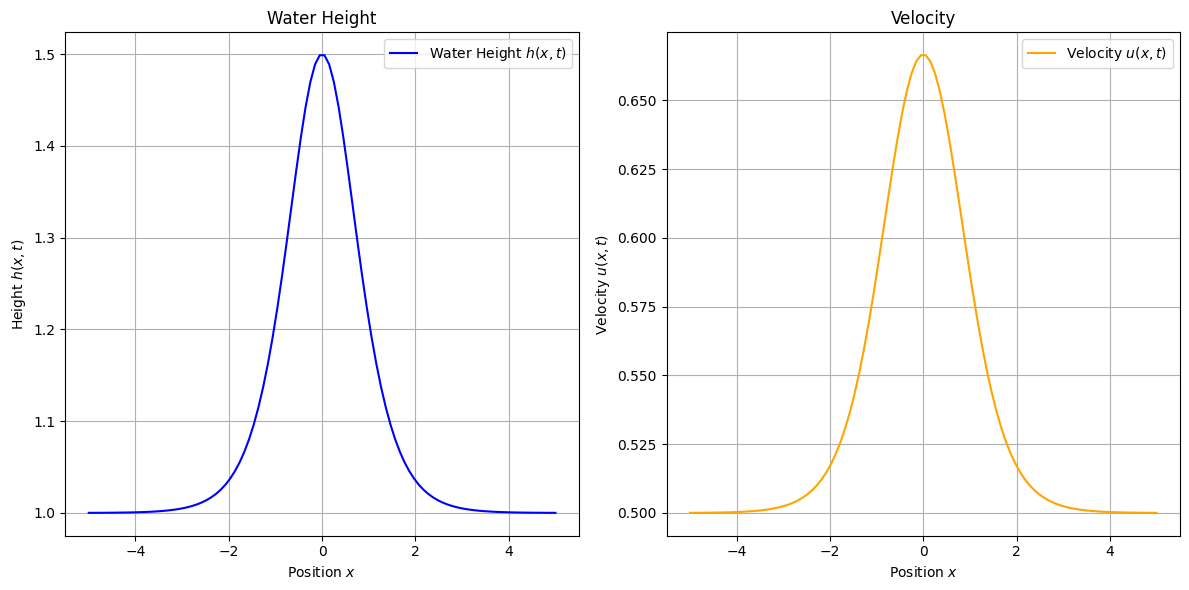

In [135]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
h0 = 1.0  # Mean water height
A = 0.5   # Amplitude
c = 1.0   # Wave speed
d = 1.0   # Width parameter

def water_height(x, t):
    """Calculate the water height at position x and time t."""
    argument = (x - c * t) / d
    return h0 + A * (1 / np.cosh(argument))**2

def velocity(x, t):
    """Calculate the velocity at position x and time t."""
    return c * (1 - A / (h0 + A * (1 / np.cosh((x - c * t) / d))**2))

# Define the range of x values
x_values = np.linspace(-5, 5, 100)  # Example positions
t = 0  # Example time

# Calculate water height and velocity
heights = water_height(x_values, t)
velocities = velocity(x_values, t)

# Create the plots
plt.figure(figsize=(12, 6))

# Plot water height
plt.subplot(1, 2, 1)
plt.plot(x_values, heights, label='Water Height $h(x,t)$', color='blue')
plt.title('Water Height')
plt.xlabel('Position $x$')
plt.ylabel('Height $h(x,t)$')
plt.grid(True)
plt.legend()

# Plot velocity
plt.subplot(1, 2, 2)
plt.plot(x_values, velocities, label='Velocity $u(x,t)$', color='orange')
plt.title('Velocity')
plt.xlabel('Position $x$')
plt.ylabel('Velocity $u(x,t)$')
plt.grid(True)
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()
# Define the range of x values
x_values = np.linspace(-5, 5, 100)  # Example positions
t = 0  # Example time

# Calculate water height and velocity
heights = water_height(x_values, t)
velocities = velocity(x_values, t)

Number of time steps: 52


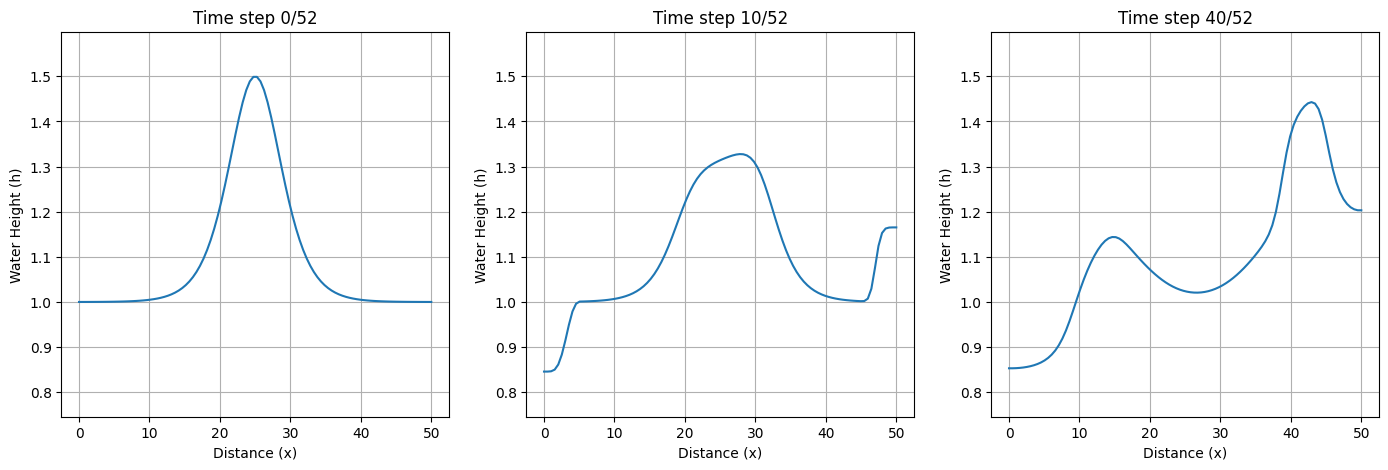

In [153]:
# Define the range of x values
x_values = np.linspace(-5, 5, 100)  # Example positions
t = 0  # Example time

# Calculate water height and velocity
h = water_height(x_values, t)
u = velocity(x_values, t)
hu = h*u

t_end = 2
h, hu, h_hist = solve_SWE_1D(t, t_end, h, hu, N, dx, CFL=0.9,g=9.81,solver='roe')

n = len(h_hist)
idx = [0, 10, 40]
subplot(h_hist, idx, L, N, save=False, filename='VSC/tex/plots/solution_1D_no_limiter.png')
#idx = [60, 100, 130]
#subplot(h_hist, idx, L, N, save=False, filename='VSC/tex/plots/solution_1D_no_limiter_2.png')
# Compute the water height at initial time

### Toro: Model Problem 1

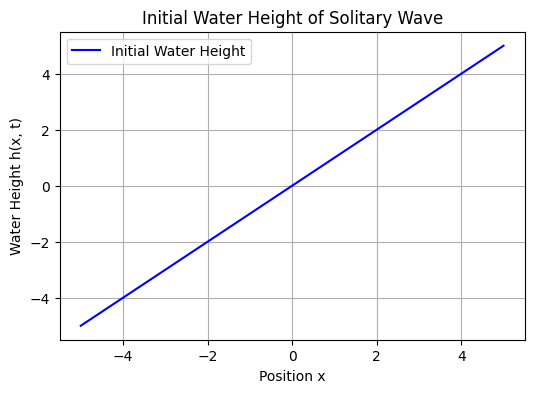

In [63]:
# Parameters
lambda_ = 1.0  
alpha = 0.5

# Function to calculate the water height at position x and time t
def water_height(x, t):
    return (x - lambda_ *t)*np.exp(alpha*t)

# Define the spatial domain and time
x = np.linspace(-5, 5, 400)  # Spatial domain from -5 to 5
t = 0                        # Initial time

# Compute the water height at initial time
h_initial = water_height(x, 0)

# Plot the initial water height
plt.figure(figsize=(6, 4))
plt.plot(x, h_initial, label='Initial Water Height', color='b')
plt.xlabel('Position x')
plt.ylabel('Water Height h(x, t)')
plt.title('Initial Water Height of Solitary Wave')
plt.legend()
plt.grid(True)
plt.show()


### Dam break solution

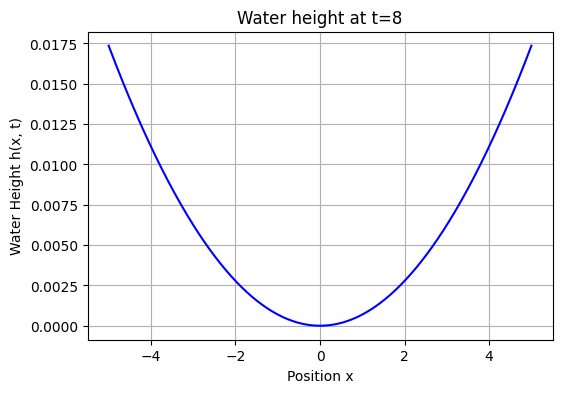

In [106]:
# Parameters
g = 10

# Function to calculate the water height at position x and time t
def water_height(x, t):
    return 4/(9*g) *(x/t)**2

def u_velocity(x, t):
    return 2/3 * x/t

# Define the spatial domain and time
x = np.linspace(-5, 5, 400)  # Spatial domain from -5 to 5
t = 8                        # Initial time

# Compute the water height at initial time
h_initial = water_height(x, t)

# Plot the initial water height
plt.figure(figsize=(6, 4))
plt.plot(x, h_initial, color='b')
plt.xlabel('Position x')
plt.ylabel('Water Height h(x, t)')
plt.title('Water height at t=' + str(t))
plt.grid(True)
plt.show()


## Test 1

Number of time steps: 490


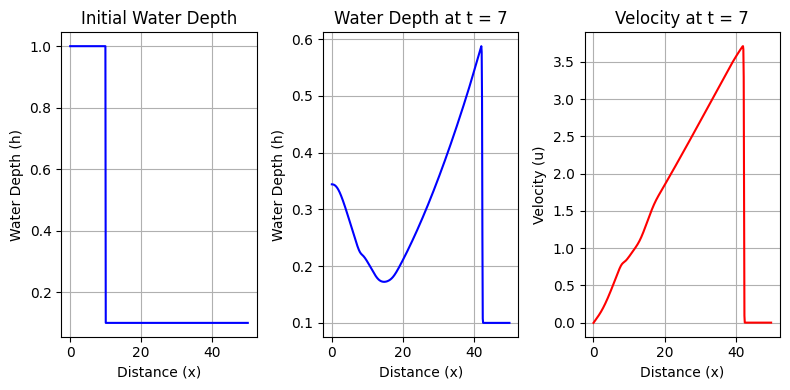

In [38]:
# Initialization
N = 500
L = 50
# Define the spatial domain and time
x = np.linspace(0, L, N)  # Spatial domain 
x0 = 10
dx = L/N

# Compute the water height at initial time
hl = 1.0
hr = 0.1
h = np.where(x < x0, hl, hr)

ul = 2.5
ur = 0.0
u = np.where(x < x0, ul, ur)

hu = h*u

#hu = np.zeros(N)
#u = np.zeros(N)

t = 0
t_end = 7

h, hu, h_hist = solve_SWE_1D(t, t_end, h, hu, N, dx, CFL=0.9,g=9.81,solver='roe')

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(8, 4))

# Plot initial water depth
axs[0].plot(x, h_hist[0], color='b')
axs[0].set_xlabel('Distance (x)')
axs[0].set_ylabel('Water Depth (h)')
axs[0].set_title('Initial Water Depth')
axs[0].grid(True)


# Plot water depth
axs[1].plot(x, h, color='b')
axs[1].set_xlabel('Distance (x)')
axs[1].set_ylabel('Water Depth (h)')
axs[1].set_title('Water Depth at t = ' + str(t_end))
axs[1].grid(True)

# Plot velocity
axs[2].plot(x, hu/h, color='r')
axs[2].set_xlabel('Distance (x)')
axs[2].set_ylabel('Velocity (u)')
axs[2].set_title('Velocity at t = ' + str(t_end))
axs[2].grid(True)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


## Test 2

Number of time steps: 157


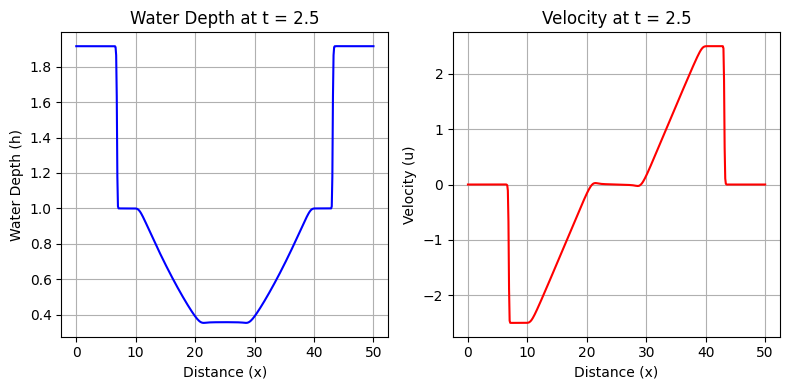

In [30]:
# Initialization
N = 500
L = 50
# Define the spatial domain and time
x = np.linspace(0, L, N)  # Spatial domain 
x0 = 25
dx = L/N

# Compute the water height at initial time
hl = 1.0
hr = 1.0
h = np.where(x < x0, hl, hr)

ul = -2.5
ur = 2.5
u = np.where(x < x0, ul, ur)

hu = h*u

#hu = np.zeros(N)
#u = np.zeros(N)

t = 0
t_end = 2.5

h, hu, h_hist = solve_SWE_1D(t, t_end, h, hu, N, dx, CFL=0.9,g=9.8,solver='roe')

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# Plot water depth
axs[0].plot(x, h, color='b')
axs[0].set_xlabel('Distance (x)')
axs[0].set_ylabel('Water Depth (h)')
axs[0].set_title('Water Depth at t = ' + str(t_end))
axs[0].grid(True)

# Plot velocity
axs[1].plot(x, hu/h, color='r')
axs[1].set_xlabel('Distance (x)')
axs[1].set_ylabel('Velocity (u)')
axs[1].set_title('Velocity at t = ' + str(t_end))
axs[1].grid(True)

# Adjust layout
plt.tight_layout()

# Show plotW
plt.show()


## Test 3

Number of time steps: 201


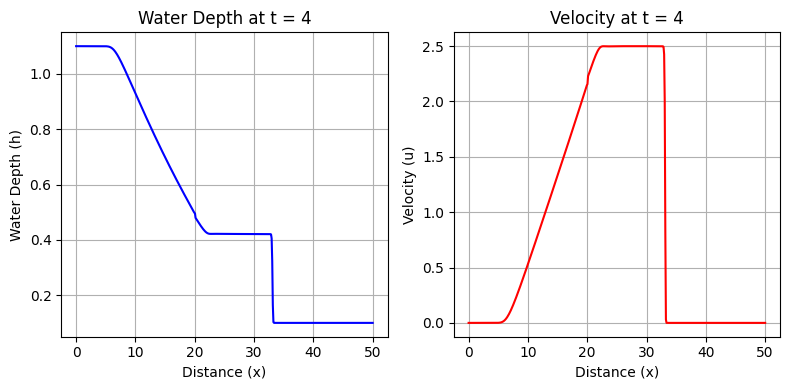

In [31]:
# Initialization
N = 500
L = 50
# Define the spatial domain and time
x = np.linspace(0, L, N)  # Spatial domain 
x0 = 20
dx = L/N

# Compute the water height at initial time
hl = 1.1
hr = 0.1
h = np.where(x < x0, hl, hr)

ul = 0.0
ur = 0.0
u = np.where(x < x0, ul, ur)

hu = h*u

#hu = np.zeros(N)
#u = np.zeros(N)

t = 0
t_end = 4

h, hu, h_hist = solve_SWE_1D(t, t_end, h, hu, N, dx, CFL=0.9,g=9.8,solver='roe')

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# Plot water depth
axs[0].plot(x, h, color='b')
axs[0].set_xlabel('Distance (x)')
axs[0].set_ylabel('Water Depth (h)')
axs[0].set_title('Water Depth at t = ' + str(t_end))
axs[0].grid(True)

# Plot velocity
axs[1].plot(x, hu/h, color='r')
axs[1].set_xlabel('Distance (x)')
axs[1].set_ylabel('Velocity (u)')
axs[1].set_title('Velocity at t = ' + str(t_end))
axs[1].grid(True)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


## Test 4

Number of time steps: 201


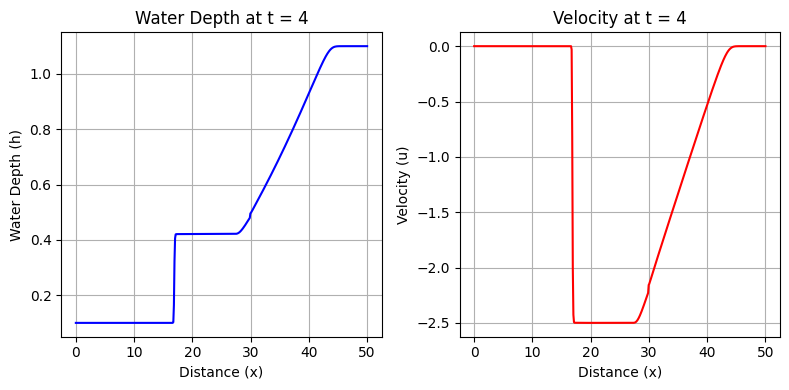

In [53]:
# Initialization
N = 500
L = 50
# Define the spatial domain and time
x = np.linspace(0, L, N)  # Spatial domain 
x0 = 30
dx = L/N
 
# Compute the water height at initial time
hl = 0.1
hr = 1.1
h = np.where(x < x0, hl, hr)

ul = 0.0
ur = 0.0
u = np.where(x < x0, ul, ur)

hu = h*u

#hu = np.zeros(N)
#u = np.zeros(N)

t = 0
t_end = 4

h, hu, h_hist = solve_SWE_1D(t, t_end, h, hu, N, dx, CFL=0.9,g=9.8,solver='roe')

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# Plot water depth
axs[0].plot(x, h, color='b')
axs[0].set_xlabel('Distance (x)')
axs[0].set_ylabel('Water Depth (h)')
axs[0].set_title('Water Depth at t = ' + str(t_end))
axs[0].grid(True)

# Plot velocity
axs[1].plot(x, hu/h, color='r')
axs[1].set_xlabel('Distance (x)')
axs[1].set_ylabel('Velocity (u)')
axs[1].set_title('Velocity at t = ' + str(t_end))
axs[1].grid(True)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


## Solve the 2D SWE using FVM

In [19]:
def roe_solver_2D_new(hL, huL, hvL, hR, huR, hvR, nx, ny, g=9.81):

    uL = huL / hL
    uR = huR / hR
    vL = hvL / hL
    vR = hvR / hR

    # Calculate Roe averages
    chat = np.sqrt(0.5*g*(hL + hR))
    sqhL = np.sqrt(hL)
    sqhR = np.sqrt(hR)
    uhat = (sqhL*uL + sqhR*uR) / (sqhL + sqhR)
    vhat = (sqhL*vL + sqhR*vR) / (sqhL + sqhR)

    # Normal velocities
    un = nx*uhat + ny*vhat

    # Calculate eigenvalues and eigenvectors
    lambda1 = np.abs(un + chat)
    lambda2 = np.abs(un)
    lambda3 = np.abs(un - chat)

    r11 = 1.0;            r12 = 0.0; r13 = 1.0 
    r21 = uhat + nx*chat; r22 = -ny*chat; r23 = uhat - nx*chat
    r31 = vhat + ny*chat; r32 = nx*chat;  r33 = vhat - ny*chat 

    # Compute wave strengths
    dh = hR - hL
    dhu = huR - huL
    dhv = hvR - hvL

    # Compute wavespeed coefficients
    dalpha = 0.5*(nx*dhu + ny*dhv - un*dh)/chat
    alpha1 = 0.5*dh + dalpha
    alpha2 = (nx*(dhv - dh*vhat) - ny*(dhu - dh*uhat))/chat
    alpha3 = 0.5*dh - dalpha

    # Compute wave strengths
    du1 = hR - hL
    du2 = huR - huL
    du3 = hvR - hvL

    # Compute the |A|*(UL - UR) 
    F1_Roe = alpha1*lambda1*r11 + alpha2*lambda2*r12 + alpha3*lambda3*r13 
    F2_Roe = alpha1*lambda1*r21 + alpha2*lambda2*r22 + alpha3*lambda3*r23
    F3_Roe = alpha1*lambda1*r31 + alpha2*lambda2*r32 + alpha3*lambda3*r33

    return F1_Roe, F2_Roe, F3_Roe

In [31]:
# Initialization
N = 200 # Number of grid points
Lx = 40 # Length of the domain in x-direction
Ly = 40 # Length of the domain in y-direction

dx = Lx / N
dy = Ly / N

# Define center and radius
xc = 20
yc = 20
R = 2.5

x = np.linspace(0, Lx, N)
y = np.linspace(0, Ly, N)

# Define the grid
X, Y = np.meshgrid(x, y)

CFL = 0.9 # CFL number
g = 9.81 # Gravity

t = 0

# Initial conditions
h0 = 0.5
h = h0 * np.ones((N, N))
hu = np.zeros((N, N))
hv = np.zeros((N, N))

# Set the initial water height (dam break problem)
h_in = 2.5
h_out = 0.5
h = np.where((X - xc)**2 + (Y - yc)**2 < R**2, h_in, h_out)  # Adjust h based on the circle

# Compute fluxes
for i in range(N-1):
    for j in range(N-1):
        hL, huL, hvL = h[i, j], hu[i, j], hv[i, j]
        hR, huR, hvR = h[i, j+1], hu[i, j+1], hv[i, j+1]

        F1, F2, F3 = roe_solver_2D_new(hL, huL, hvL, hR, huR, hvR, N, 0, g=9.81)



In [36]:
def roe_solver_2D(hL, huL, hvL, hR, huR, hvR, g=9.81):

    # Calculate Roe averages
    h_tilde = np.sqrt(hL*hR) 
    u_tilde = (np.sqrt(hL) * huL / hL + np.sqrt(hR) * huR / hR) / (np.sqrt(hL) + np.sqrt(hR))
    v_tilde = (np.sqrt(hL) * hvL / hL + np.sqrt(hR) * hvR / hR) / (np.sqrt(hL) + np.sqrt(hR))
    
    cL = np.sqrt(g * hL)
    cR = np.sqrt(g * hR)
    c = np.sqrt(1/2*(cL**2 + cR**2))

    # Compute wave strengths
    du1 = hR - hL
    du2 = huR - huL
    du3 = hvR - hvL

    # Calculate eigenvalues and eigenvectors
   # lambda1 = u_tilde - c
   # lambda2 = u_tilde
   # lambda3 = u_tilde + c
    lambda1 = np.abs(u_tilde - c)
    lambda2 = np.abs(u_tilde)
    lambda3 = np.abs(u_tilde + c)
    R1 = np.array([1, lambda1, v_tilde])
    R2 = np.array([0, 0, 1])
    R3 = np.array([1, lambda3, v_tilde])

    alpha1 = (du1 * lambda3 - du2) / (2 * c)
    alpha2 = du3 - v_tilde * du1
    alpha3 = (-du1 * lambda1 + du2) / (2 * c)

    # Compute F-fluxes
    F_L = np.array([huL, huL ** 2 / hL + 0.5 * g * hL ** 2, huL * hvL / hL])
    F_R = np.array([huR, huR ** 2 / hR + 0.5 * g * hR ** 2, huR * hvR / hR])

    # Compute the Roe flux
    F = 0.5 * (F_L + F_R) - 0.5 * (alpha1 * np.abs(lambda1) * R1 + alpha2 * np.abs(lambda2) * R2 + alpha3 * np.abs(lambda3) * R3)

    # Compute G-fluxes
    G_L = np.array([hvL, huL * hvL / hL, hvL ** 2 / hL + 0.5 * g * hL ** 2])
    G_R = np.array([hvR, huR * hvR / hR, hvR ** 2 / hR + 0.5 * g * hR ** 2])

    # Compute the Roe flux
    G = 0.5 * (G_L + G_R) - 0.5 * (alpha1 * np.abs(lambda1) * R1 + alpha2 * np.abs(lambda2) * R2 + alpha3 * np.abs(lambda3) * R3)

    return F, G

In [67]:
def compute_interface_fluxes_2D(h, hu, hv, N, g):
    fluxes_x = np.zeros((3, N, N+1)) # ændre fra N+1, N til N, N+1
    fluxes_y = np.zeros((3, N+1, N)) # ændre fra N, N+1 til N+1, N

    # Compute x-direction fluxes
    for i in range(N):
        for j in range(N-1):
            hL, huL, hvL = h[i, j], hu[i, j], hv[i, j]
            hR, huR, hvR = h[i, j+1], hu[i, j+1], hv[i, j+1]
            fluxes_x[:, i, j+1], _ = roe_solver_2D(hL, huL, hvL, hR, huR, hvR, g)

    # Compute y-direction fluxes
    for i in range(N-1):
        for j in range(N):
            hL, huL, hvL = h[i, j], hu[i, j], hv[i, j]
            hR, huR, hvR = h[i+1, j], hu[i+1, j], hv[i+1, j]
            _, fluxes_y[:, i+1, j] = roe_solver_2D(hL, huL, hvL, hR, huR, hvR, g)

    return fluxes_x, fluxes_y

def update_variables_2D(h, hu, hv, dt, fluxes_x, fluxes_y, N, dx, dy):
    h_new = h.copy()
    hu_new = hu.copy()
    hv_new = hv.copy()

    for i in range(1, N-1):
        for j in range(1, N-1):
            h_new[i, j] = np.max(h[i, j] - dt/dx * (fluxes_x[0, i, j+1] - fluxes_x[0, i, j]) - dt/dy * (fluxes_y[0, i+1, j] - fluxes_y[0, i, j]) ,0)
            hu_new[i, j] = hu[i, j] - dt/dx * (fluxes_x[1, i, j+1] - fluxes_x[1, i, j]) - dt/dy * (fluxes_y[1, i+1, j] - fluxes_y[1, i, j])
            hv_new[i, j] = hv[i, j] - dt/dx * (fluxes_x[2, i, j+1] - fluxes_x[2, i, j]) - dt/dy * (fluxes_y[2, i+1, j] - fluxes_y[2, i, j])

    # Apply reflective boundary conditions
    h_new[0, :] = h_new[1, :]
    hu_new[0, :] = -hu_new[1, :]
    hv_new[0, :] = -hv_new[1, :]
    h_new[:, 0] = h_new[:, 1]
    hu_new[:, 0] = -hu_new[:, 1]
    hv_new[:, 0] = -hv_new[:, 1]
    h_new[N-1, :] = h_new[N-2, :]
    hu_new[N-1, :] = -hu_new[N-2, :]
    hv_new[N-1, :] = -hv_new[N-2, :]
    h_new[:, N-1] = h_new[:, N-2]
    hu_new[:, N-1] = -hu_new[:, N-2]
    hv_new[:, N-1] = -hv_new[:, N-2]
    
    return h_new, hu_new, hv_new

def solve_SWE_2D(t, t_end, h, hu, hv, N, dx, dy, CFL=0.9, g=9.81):
    # Store the intermediate states
    h_hist = []
    hu_hist = []
    hv_hist = []
    dt_hist = []

    h_hist.append(h.copy())
    hu_hist.append(hu.copy())
    hv_hist.append(hv.copy())

    # Main loop
    while t < t_end:
        # Compute the time step
        u = hu/h
        v = hv/h
        c = np.sqrt(g*h)
        dt = CFL * min(dx, dy) / np.max(np.abs(u) + np.abs(v) + c)

        if t + dt > t_end:
            dt = t_end - t

        # Compute the fluxes at the interfaces
        fluxes_x, fluxes_y = compute_interface_fluxes_2D(h, hu, hv, N, g)

        # Update the variables
        h, hu, hv = update_variables_2D(h, hu, hv, dt, fluxes_x, fluxes_y, N, dx, dy)

        # Store the results
        h_hist.append(h.copy())
        hu_hist.append(hu.copy())
        hv_hist.append(h.copy())
        dt_hist.append(dt)

        # Update the time
        t += dt
  
    n = len(dt_hist)
    print(f"Number of time steps: {n}")

    return h, hu, hv, h_hist, dt_hist



## Idealised Circular Dam: Reference solutions

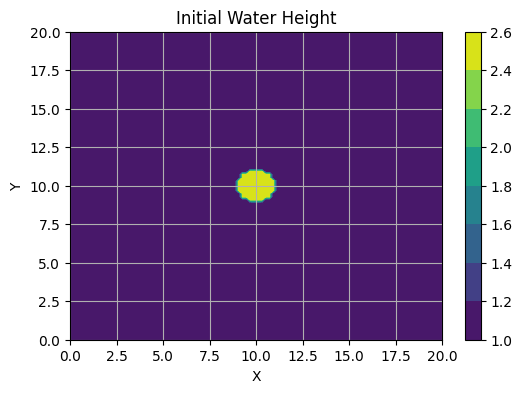

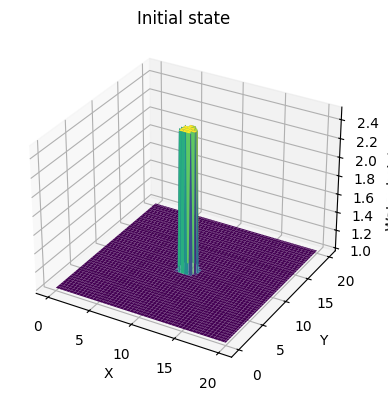

In [91]:
# Initialization
N = 100 # Number of grid points
Lx = 20 # Length of the domain in x-direction
Ly = 20 # Length of the domain in y-direction

dx = Lx / N
dy = Ly / N

# Define center and radius
xc = 10
yc = 10
R = 1

x = np.linspace(0, Lx, N)
y = np.linspace(0, Ly, N)

# Define the grid
X, Y = np.meshgrid(x, y)

CFL = 0.9 # CFL number
g = 9.81 # Gravity

t = 0

# Initial conditions
h0 = 0.5
h = h0 * np.ones((N, N))
hu = np.zeros((N, N))
hv = np.zeros((N, N))

# Set the initial water height (dam break problem)
h_in = 2.5
h_out = 1
h = np.where((X - xc)**2 + (Y - yc)**2 < R**2, h_in, h_out)  # Adjust h based on the circle

# Plot the initial water height
plt.figure(figsize=(6, 4))
plt.contourf(X, Y, h, cmap='viridis')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Initial Water Height')
plt.colorbar()
plt.grid(True)
plt.show()

# Plot h at different time steps
fig = plt.figure(figsize=(4, 4))

# Initial state
ax1 = fig.add_subplot(111, projection='3d')
surf1 = ax1.plot_surface(X, Y, h, cmap='viridis')
ax1.set_xlabel('X')
ax1.set_ylabel('Y') 
ax1.set_zlabel('Water height (h)')
ax1.set_title('Initial state')
plt.tight_layout()
plt.show()


In [92]:
# Solve the problem
t_end = 0.1
h, hu, hv, h_hist, dt_hist = solve_SWE_2D(t, t_end, h, hu, hv, N, dx, dy, CFL=0.9, g=9.81)

Number of time steps: 5


In [96]:
np.min(h)

np.float64(-0.049091390395736234)

In [95]:
h

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

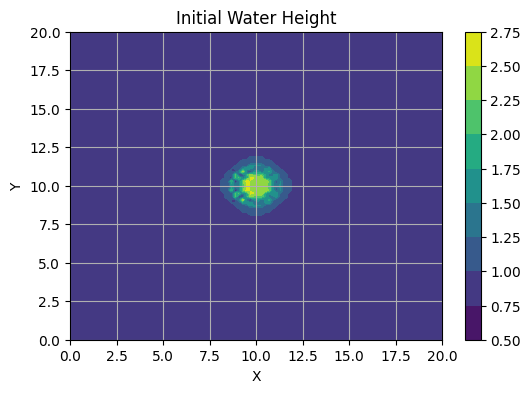

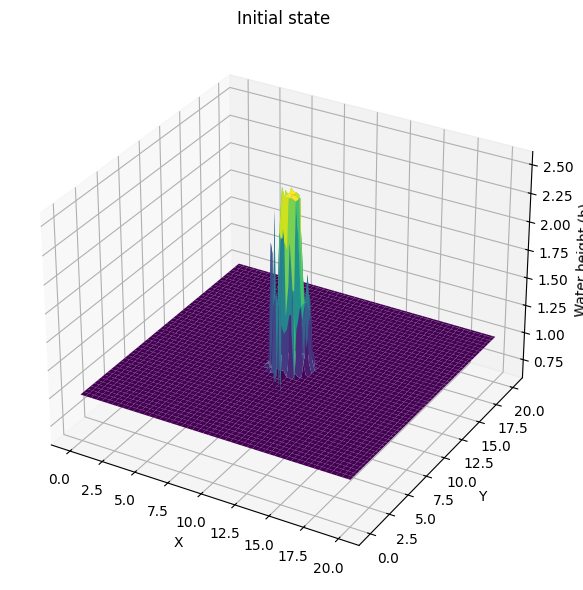

In [98]:
idx = 4

# Plot the initial water height
plt.figure(figsize=(6, 4))
plt.contourf(X, Y, h_hist[idx], cmap='viridis')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Initial Water Height')
plt.colorbar()
plt.grid(True)
plt.show()

# Plot h at different time steps
fig = plt.figure(figsize=(6, 6))

# Initial state
ax1 = fig.add_subplot(111, projection='3d')
surf1 = ax1.plot_surface(X, Y, h_hist[idx], cmap='viridis')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Water height (h)')
ax1.set_title('Initial state')
plt.tight_layout()
plt.show()

# Ekstra

In [ ]:
# Initialization
N = 20 # Number of grid points
L = 1 # Length of the domain
dx = L / N
dy = L / N

x = np.linspace(0, L, N)
y = np.linspace(0, L, N)

CFL = 0.9 # CFL number
g = 9.81 # Gravity

t = 0
t_end = 0.1

# Initial conditions
h = np.ones((N, N))
hu = np.zeros((N, N))
hv = np.zeros((N, N))

# Set the initial water height (dam break problem)
h[:int(N/2), :int(N/2)] = 2.0  # higher water level in the corner

# Solve the problem
h, hu, hv, h_hist, dt_hist = solve_SWE_2D(t, t_end, h, hu, hv, N, dx, dy, CFL=0.9, g=9.81)

In [ ]:
# Define the grid
x = np.linspace(0, L, N)
y = np.linspace(0, L, N)
X, Y = np.meshgrid(x, y)

idx = [0, 2, 5]

# Plot h at different time steps
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Initial state
contour1 = axs[0].contourf(X, Y, h_hist[0], cmap='viridis')
axs[0].set_xlabel('X')
axs[0].set_ylabel('Y')
axs[0].set_title('Initial state')
fig.colorbar(contour1, ax=axs[0])

# Middle state
contour2 = axs[1].contourf(X, Y, h_hist[idx[1]], cmap='viridis')
axs[1].set_xlabel('X')
axs[1].set_ylabel('Y')
axs[1].set_title(f'Time Step {idx[1]}')
fig.colorbar(contour2, ax=axs[1])

# Final state
contour3 = axs[2].contourf(X, Y, h_hist[idx[2]], cmap='viridis')
axs[2].set_xlabel('X')
axs[2].set_ylabel('Y')
axs[2].set_title(f'Time Step {idx[2]}')
fig.colorbar(contour3, ax=axs[2])

plt.tight_layout()
plt.show()


In [ ]:
# Define the grid
x = np.linspace(0, L, N)
y = np.linspace(0, L, N)
X, Y = np.meshgrid(x, y)

idx = [0, 2, 10]

# Plot h at different time steps
fig = plt.figure(figsize=(15, 9))

# Initial state
ax1 = fig.add_subplot(131, projection='3d')
surf1 = ax1.plot_surface(X, Y, h_hist[0], cmap='viridis')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Water height (h)')
ax1.set_title('Initial state')

# Middle state
ax2 = fig.add_subplot(132, projection='3d')
surf2 = ax2.plot_surface(X, Y, h_hist[idx[1]], cmap='viridis')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Water height (h)')
ax2.set_title(f'Time Step {idx[1]}')

# Final state
ax3 = fig.add_subplot(133, projection='3d')
surf3 = ax3.plot_surface(X, Y, h_hist[idx[2]], cmap='viridis')
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.set_zlabel('Water height (h)')
ax3.set_title(f'Time Step {idx[2]}')

plt.tight_layout()
plt.show()
